## Figure tracer transport 

In [1]:
#import gsw as sw # Gibbs seawater package
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gspec
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import xarray as xr
import canyon_tools.readout_tools as rout 
import canyon_tools.metrics_tools as mpt

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [3]:
sns.set_context('paper')
sns.set_style('white')
plt.rcParams.update({'font.size': 11})

In [65]:
def plot_transports_CS(g0,g1,g2,g3,g4,g5, dfcan, dfdif, color, lab):
    
    ax0 = plt.subplot(g0)
    ax1 = plt.subplot(g1)
    ax2 = plt.subplot(g2)
    ax3 = plt.subplot(g3)
    ax4 = plt.subplot(g4)
    ax5 = plt.subplot(g5)
    
    axs = [ax0,ax1,ax2,ax3,ax4,ax5]
      
    for ax in axs:
        ax.axhline(0, color='gold')
        ax.tick_params(axis='y', pad=0)
        ax.tick_params(axis='x', pad=0.05)
        ax.grid(which='both',color='0.9', linestyle='-')
        ax.set_ylim(-50, 50)
        ax.set_xlabel('Days', labelpad=0)
        ax.set_xticks([0,3,6,9])
    for ax in axs[1:]:
        #ax.set_yticks([-200,-100,0,100,200])
        ax.set_yticklabels(['','','','','',''])
   
    # Tracers
    vertical =  dfcan.Vert_adv_trans_sb # only advective parts, ignoring diffusve for now      
    ax0.plot(np.arange(1,19,1)/2.0,(vertical)/1E6,color=color, label=lab)
    ax1.plot(np.arange(1,19,1)/2.0,(dfcan.CS1_adv_trans+dfcan.CS2_adv_trans)/1E6,color=color, label=lab)
    ax2.plot(np.arange(1,19,1)/2.0,(dfcan.CS3_adv_trans )/1E6,color=color, label=lab)
    ax3.plot(np.arange(1,19,1)/2.0,(dfcan.CS4_adv_trans+dfcan.CS5_adv_trans)/1E6,color=color, label=lab)
    ax4.plot(np.arange(1,19,1)/2.0,(dfcan.CS6_adv_trans )/1E6,color=color, label=lab)

    total = ( (dfcan.CS1_adv_trans ) +
              (dfcan.CS2_adv_trans ) +
              (dfcan.CS3_adv_trans ) +
              (dfcan.CS4_adv_trans ) +
              (dfcan.CS5_adv_trans ) +
              (dfcan.CS6_adv_trans ) +
               vertical)

    ax5.plot(np.arange(1,19,1)/2.0,total/1E6,color=color, label=lab)
    return(ax0,ax1,ax2,ax3,ax4,ax5)   
def plot_can_effect(gs_c, dfcan, dfdif, dfcanNoC, dfdifNoC, color, lab, id_sup):
    ax = plt.subplot(gs_c, xticks=[])
    ax.axhline(0, color='gold')
    canyon = tot_trans(dfcan, dfdif)
    no_canyon = tot_trans(dfcanNoC, dfdifNoC)
    ax.plot(np.arange(1,19,1)/2.0,(canyon-no_canyon)/1E5,color=color, label=lab)
    ax.tick_params(axis='y', pad=0.5)
    ax.grid(which='both',color='0.9', linestyle='-')
    ax.yaxis.tick_right()
    if lab =='ARGO':
        ax.text(0.8,0.8,id_sup,transform=ax.transAxes)

    return(ax)
def tot_trans(dfcan, dfdif):
    vertical = (dfdif.Vert_dif_trans_sb + dfcan.Vert_adv_trans_sb)   
    total = ( (dfcan.CS1_adv_trans ) +
              (dfcan.CS2_adv_trans ) +
              (dfcan.CS3_adv_trans ) +
              (dfcan.CS4_adv_trans ) +
              (dfcan.CS5_adv_trans ) +
              (dfcan.CS6_adv_trans ) +
               vertical)
    return(total)

def plotCSPos(ax,CS1,CS2,CS3,CS4,CS5,CS6):
    ax.axvline(CS1,color='k',linestyle=':')
    ax.axvline(CS2,color='k',linestyle=':')
    ax.axvline(CS3,color='k',linestyle=':')
    ax.axvline(CS4,color='k',linestyle=':')
    ax.axvline(CS5,color='k',linestyle=':')
    ax.axvline(CS6,color='k',linestyle=':')

def plot_CS_slice(fig, gs_a, gs_b, t_slice, x_slice, x_slice_vert, y_slice_vert, z_slice, z_slice_zoom, y_ind, z_ind,
                  grid,Flux,FluxV,unit):
    
    ax_a = plt.subplot(gs_a)#,xticks=[])
    ax_b = plt.subplot(gs_b)#,xticks=[])
    
    areas = (np.expand_dims(grid.dxF.isel(X=x_slice,Y=y_ind).data,0))*(np.expand_dims(grid.drF.isel(Z=z_slice).data,1))

    # Zoom shelf   ---------------------------------------------------------------------------
    cnt = ax_a.contourf(grid.X.isel(X=x_slice)/1000,
                       grid.Z.isel(Z=z_slice_zoom),
                       Flux.isel(Zmd000104=z_slice_zoom, X=x_slice)/areas[z_slice_zoom,:],
                       16,cmap=cmo.cm.tarn,
                       vmax=np.max(Flux.isel(Zmd000104=z_slice_zoom,X=x_slice)/areas[z_slice_zoom,:]), 
                       vmin=-np.max(Flux.isel(Zmd000104=z_slice_zoom,X=x_slice)/areas[z_slice_zoom,:]))
    ax_a.contourf(grid.X.isel(X=x_slice)/1000,
                 grid.Z.isel(Z=z_slice_zoom),
                 grid.HFacC.isel(Z=z_slice_zoom,Y=y_ind,X=x_slice),
                 [0,0.1], colors='#a99582')

    cb_a = fig.colorbar(cnt, ax=ax_a)
    cb_a.ax.yaxis.set_tick_params(pad=1.5)

    ax_a.set_ylabel('Depth / m',labelpad=0.0)
    ax_a.text(0.001,0.05,'%s' %unit,transform=ax_a.transAxes, fontsize=8, color='k',fontweight='bold')    

    # Vertical section ---------------------------------------------------------------------------
    cnt=ax_b.contourf(grid.X.isel(X=x_slice_vert)/1000,
                     grid.Y.isel(Y=y_slice_vert)/1000,
                     100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert]),
                     16,cmap=cmo.cm.tarn,
                     vmax= np.max(100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert])),
                     vmin=-np.max(100*(FluxV.isel(X=x_slice_vert,Y=y_slice_vert).data)/(grid.rA[y_slice_vert,x_slice_vert])))
    ax_b.contourf(grid.X.isel(X=x_slice_vert)/1000, 
                 grid.Y.isel(Y=y_slice_vert)/1000,
                 grid.HFacC.isel(Z=z_ind,X=x_slice_vert,Y=y_slice_vert),
                 [0,0.1], colors='#a99582')
    
    cb_b=fig.colorbar(cnt, ax=ax_b)#,ticks=[-2,-1,0,1,2,3,4])
    cb_b.ax.yaxis.set_tick_params(pad=1.5)
    ax_b.set_ylabel('C-S distance / km', labelpad=0)
    ax_b.set_aspect(1)
    
    return(ax_a,ax_b)

In [5]:
#Exp
Grid = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/gridGlob.nc' 
GridOut = Dataset(Grid)

GridNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/gridGlob.nc' 
GridNoCOut = Dataset(GridNoC)

State = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/stateGlob.nc' 
StateNoC = '/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/02_Ast03_No_Cny/stateGlob.nc' 

In [17]:
units = ['$10^5$ $\mu$mol kg$^{-1}$ m$^3$s$^{-1}$',
         '$10^5$ nM m$^3$s$^{-1}$',
         '$10^5$ $\mu$mol kg$^{-1}$ m$^3$s$^{-1}$']
tracers = ['TR03','TR08','TR09']
tr_labels = ['Oxygen','Methane','DIC']

exps = ['UPW_10TR_BF2_AST/01_Ast03',
        'UPW_10TR_BF2_AST/03_Ast03_Argo',
        'UPW_10TR_BF4_BAR/01_Bar03',
        'UPW_10TR_BF4_BAR/03_Bar03_Path']

expsNoC = ['UPW_10TR_BF2_AST/02_Ast03_No_Cny',
           'UPW_10TR_BF2_AST/04_Ast03_No_Cny_Argo',
           'UPW_10TR_BF4_BAR/02_Bar03_No_Cny',
           'UPW_10TR_BF4_BAR/04_Bar03_No_Cny_Path']

colors = ['steelblue', 'skyblue', 'orangered', 'lightsalmon']
labels = ['Astoria','ARGO', 'Barkley', 'Pathways']
subplots_id = ['a3', 'b3', 'c3',]

In [7]:
t_slice = slice(10,20)
x_slice = slice(0,400)
x_slice_vert = slice(120,240)
y_slice_vert = slice(130,230)
z_slice = slice(0,80)
z_slice_zoom = slice(0,31)
y_ind = 130 # sb index
z_ind = 30 # sb index

/home/kramosmu/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


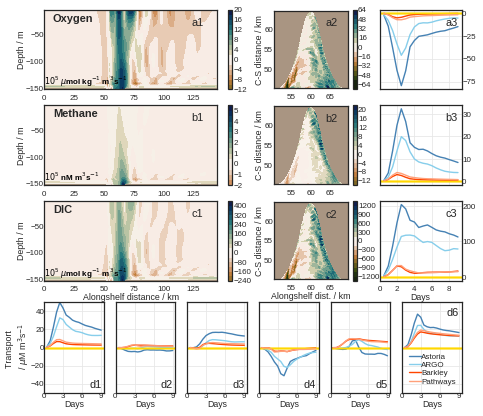

In [63]:
fig = plt.figure(figsize = (7.48,7.05))

gg = gspec.GridSpec(2, 1, hspace=0.12, height_ratios=[3,1])
gs = gspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gg[0])
gs1 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0],hspace=0.15,wspace=0.1,width_ratios=[1,0.43,0.38])
gs3 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[1],hspace=0.15,wspace=0.1,width_ratios=[1,0.43,0.38])
gs4 = gspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[2],hspace=0.15,wspace=0.1,width_ratios=[1,0.43,0.38])
gs5 = gspec.GridSpecFromSubplotSpec(1, 6, subplot_spec=gg[1])

ggs = [gs1,gs3,gs4]
grid = xr.open_dataset(Grid)

# This is horrible ------------------------------------------------------------------------------------
# - Oxygen
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[0])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr03[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr03[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr03[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr03[t_slice,z_ind,:,:]+flux.DFrETr03[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax3,ax4 = plot_CS_slice(fig, gs1[0], gs1[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                        z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[0])

ax3.text(0.05,0.85,tr_labels[0],fontweight='bold',transform=ax3.transAxes)
ax3.text(0.85,0.8,'a1',transform=ax3.transAxes)
ax4.text(0.7,0.8,'a2',transform=ax4.transAxes)
ax3.tick_params(axis='y', pad=0.5)
ax4.tick_params(axis='y', pad=0.5)

# - Methane
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[1])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr08[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr08[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr08[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr08[t_slice,z_ind,:,:]+flux.DFrETr08[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax7,ax8 = plot_CS_slice(fig, gs3[0], gs3[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                        z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[1])
ax7.text(0.05,0.85,tr_labels[1],fontweight='bold',transform=ax7.transAxes)
ax7.text(0.85,0.8,'b1',transform=ax7.transAxes)
ax8.text(0.7,0.8,'b2',transform=ax8.transAxes)
ax7.tick_params(axis='y', pad=0.5)
ax8.tick_params(axis='y', pad=0.5)

# - DIC
flux_file = ('/data/kramosmu/results/TracerExperiments/UPW_10TR_BF2_AST/01_Ast03/Flux%sGlob.nc' %tracers[2])
flux = xr.open_dataset(flux_file)

adv_flux_AP = (flux.ADVyTr09[t_slice,:,y_ind,:]).mean(dim='T')
dif_flux_AP = (flux.DFyETr09[t_slice,:,y_ind,:]).mean(dim='T')
Flux = adv_flux_AP + dif_flux_AP

adv_fluxV_AP = (flux.ADVrTr09[t_slice,z_ind,:,:]).mean(dim='T')
dif_fluxV_AP = (flux.DFrITr09[t_slice,z_ind,:,:]+flux.DFrETr09[t_slice,z_ind,:,:]).mean(dim='T')
FluxV = adv_fluxV_AP + dif_fluxV_AP  

ax9,ax10 = plot_CS_slice(fig, gs4[0], gs4[1],t_slice, x_slice, x_slice_vert, y_slice_vert, 
                         z_slice, z_slice_zoom, y_ind, z_ind, grid,Flux,FluxV, units[2])
ax9.text(0.05,0.85,tr_labels[2],fontweight='bold',transform=ax9.transAxes)
ax9.text(0.85,0.8,'c1',transform=ax9.transAxes)
ax10.text(0.7,0.8,'c2',transform=ax10.transAxes)
ax9.tick_params(axis='y', pad=0.5)
ax10.tick_params(axis='y', pad=0.5)
#ax9.set_xticks([20,40,60,80,100,120,140])
#ax10.set_xticks([60,80,100])
ax9.set_xlabel('Alongshelf distance / km', labelpad=0)
ax10.set_xlabel('Alongshelf dist. / km', labelpad=0)
#------------------------------------------------------------------------------------------------------------
# - Canyon Effect
for tr, unit, tr_lab, gss, id_sup in zip(tracers, units, tr_labels, ggs,subplots_id):
    for exp,expNoC, color, lab in zip(exps,expsNoC, colors, labels):
        # net canyon effect
        file = ('/data/kramosmu/results/TracerExperiments/%s/adv%s_CS_transports.nc' %(exp,tr))
        filedif = ('/data/kramosmu/results/TracerExperiments/%s/dif%s_CS_transports.nc' %(exp,tr))
        fileNoC = ('/data/kramosmu/results/TracerExperiments/%s/adv%s_CS_transports.nc' %(expNoC,tr))
        filedifNoC = ('/data/kramosmu/results/TracerExperiments/%s/dif%s_CS_transports.nc' %(expNoC,tr))

        dfcan = xr.open_dataset(file)
        dfdif = xr.open_dataset(filedif)
        dfcanNoC = xr.open_dataset(fileNoC)
        dfdifNoC = xr.open_dataset(filedifNoC)
        axx = plot_can_effect(gss[2], dfcan, dfdif, dfcanNoC, dfdifNoC, color, lab, id_sup)
        axx.set_xticks([0,2,4,6,8])
        axx.set_xticklabels(['','','','',''])
    if tr_lab == 'DIC':
        axx.set_xticklabels([0,2,4,6,8])
        axx.set_xlabel('Days', labelpad=0)
        
#-------------------------------------------------------------------------------------------------------------
#- Linear profile cross-shelf transport through CS sections
tr = tracers[1]
unit = units[1]
tr_lab = tr_labels[1]
for exp, color, lab in zip(exps, colors, labels):
    # net canyon effect
    file = ('/data/kramosmu/results/TracerExperiments/%s/adv%s_CS_transports.nc' %(exp,tr))
    filedif = ('/data/kramosmu/results/TracerExperiments/%s/dif%s_CS_transports.nc' %(exp,tr))

    dfcan = xr.open_dataset(file)
    dfdif = xr.open_dataset(filedif)
    axa,axb,axc,axd,axe,axf,= plot_transports_CS(gs5[0],gs5[1],gs5[2],gs5[3],gs5[4],gs5[5], dfcan, dfdif, color, lab)

    axf.legend(ncol=1,handletextpad=0 , labelspacing=0.1, handlelength=1.5)
#---------------------------------------------------------------------------------------------------------
# - aesthetics

axa.set_ylabel('Transport \n / $\mu$M m$^3$s$^{-1}$', labelpad=0)
axa.text(0.75,0.05,'d1',transform=axa.transAxes)
axb.text(0.75,0.05,'d2',transform=axb.transAxes)
axc.text(0.75,0.05,'d3',transform=axc.transAxes)
axd.text(0.75,0.05,'d4',transform=axd.transAxes)
axe.text(0.75,0.05,'d5',transform=axe.transAxes)
axf.text(0.75,0.85,'d6',transform=axf.transAxes)

plt.savefig('tracer_transport_rev01.eps',format='eps', bbox_inches='tight')